# SOC stock change by land cover type
### Python libraries

In [5]:
import sys
sys.path.append("../../src/")

import matplotlib.pyplot as plt
from dask.distributed import Client

from utils.data import VectorData, LandCoverData, LandCoverRasterData
from utils.calculations import LandCoverStatistics

In [2]:
client = Client()  # start distributed scheduler locally.  Launch dashboard
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 14.98 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44113,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 14.98 GiB
Comm: tcp://127.0.0.1:46245,Total threads: 4
Dashboard: http://127.0.0.1:43397/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:33723,


### Utils

In [54]:
pix_res = 6.25
t_to_g = 1e6

def get_plot(data, land_cover_colors, land_cover_labels, categories=None):
    categories = list(data.keys())

    lists_labels = [list(value.keys()) for value in data.values()]
    labels = list(set([item for sublist in lists_labels for item in sublist]))


    # Calculate the positions of the bars on the y-axis
    bar_positions = range(len(categories))

    # Create the plot
    fig, ax = plt.subplots()

    for n, label in enumerate(labels):
        values_positive = []
        values_negative = []
        for category in categories[::-1]:
            data_dict = data[category]
            if label in data_dict.keys():
                value = data_dict[label]
                if value > 0:
                    values_positive.append(value*pix_res*t_to_g)
                    values_negative.append(0)
                else:
                    values_negative.append(value*pix_res*t_to_g)
                    values_positive.append(0)
            else:
                values_negative.append(0)
                values_positive.append(0)

        if n == 0:
            ax.barh(bar_positions, values_positive, label=land_cover_labels[label], color=land_cover_colors[label])
            ax.barh(bar_positions, values_negative, color=land_cover_colors[label])

            values_positive_pre = values_positive
            values_negative_pre = values_negative
        elif n == 1:
            ax.barh(bar_positions, values_positive, left=values_positive_pre, label=land_cover_labels[label],
                    color=land_cover_colors[label])
            ax.barh(bar_positions, values_negative, left=values_negative_pre, color=land_cover_colors[label])

            values_positive_pre = [values_positive_pre[i] + values_positive[i] for i in range(len(values_positive))]
            values_negative_pre = [values_negative_pre[i] + values_negative[i] for i in range(len(values_negative))]
        else:
            ax.barh(bar_positions, values_positive, left=values_positive_pre, label=land_cover_labels[label],
                    color=land_cover_colors[label])
            ax.barh(bar_positions, values_negative, left=values_negative_pre, color=land_cover_colors[label])

            values_positive_pre = [values_positive_pre[i] + values_positive[i] for i in range(len(values_positive))]
            values_negative_pre = [values_negative_pre[i] + values_negative[i] for i in range(len(values_negative))]

    # Add a dashed line at x = 0
    ax.axvline(0, color='black', linestyle='dashed')

    ## Set the y-axis ticks and labels
    ax.set_yticks(bar_positions)
    
    categories = [land_cover_labels[str(category)] for category in categories]
    ax.set_yticklabels(categories[::-1])
    ax.yaxis.set_ticks_position('none')
    ax.set_ylabel('Land Cover 2018')

    # Set the x-axis label
    ax.set_xlabel('SOC stock change (g C)')

    # Remove the frame
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a legend
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Set the title of the legend
    legend.set_title('Land Cover 2000')

    # Expand the plot's size to accommodate the legend
    plt.subplots_adjust(right=0.8)

    return plt

## Compute Land Cover Statistics
### Recent
#### Compute statistics

In [3]:
RASTER_PATH = '../../data/processed/raster_data/'
vector_path = '../../data/processed/vector_data/'
vector_prefixes = ['political_boundaries']#['political_boundaries', 'biomes']
read_data_from = 'local_dir'
variable = 'stocks'
group_type = 'recent'
READ_DATA_FROM = 'local_dir'
SCENARIOS = None

# Read vector data
print("Reading vector data!")
vector = VectorData(vector_path, vector_prefixes)
vector_data_0 = vector.read_data(suffix='_0.geojson')
vector_data_1 = vector.read_data(suffix='_1.geojson')
vector_data_0['political_boundaries_0'] = vector_data_0['political_boundaries_0'][vector_data_0['political_boundaries_0']['gid_0'].isin(['ESP'])]
vector_data_1['political_boundaries_1'] = vector_data_1['political_boundaries_1'][vector_data_1['political_boundaries_1']['gid_0'].isin(['ESP'])]

# Read raster data
print("Reading raster data!")
lc_metadata = LandCoverData()
raster = LandCoverRasterData(group_type=group_type, data_from=READ_DATA_FROM, path=RASTER_PATH)
raster_data = raster.read_data() 

# Compute Land Cover Statistics
print("Compute Land Cover Statistics!")
data = {}
lc_statistics = LandCoverStatistics(group_type, raster_data, lc_metadata, SCENARIOS)
# compute level 1 geometries' values
print("Level 1 geometries.")
data.update(lc_statistics.compute_level_1_data(vector_data_1))
# compute level 0 geometries' values
print("Level 0 geometries.")
data.update(lc_statistics.compute_level_0_data(vector_data_0))

### Save data
#print("Saving the data!")
#for geom_type in vector_prefixes:
#    df = pd.concat([data[key] for key in data if geom_type in key])
#    df = df.sort_values(['id_0', 'id'])
#    df['variable'] = variable
#    df['group_type'] = group_type
##   df.to_csv(f"../data/processed/precalculations/{geom_type}_land_cover_{group_type}.csv", index=False)

Reading vector data!


100%|██████████| 1/1 [00:11<00:00, 11.87s/it]


Reading raster data!
Compute Land Cover Statistics!
Level 1 geometries.
Computing land cover statistics for vector data -> political_boundaries_1


100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


Level 0 geometries.
Computing land cover statistics for vector data -> political_boundaries_0


100%|██████████| 1/1 [00:00<00:00, 523.57it/s]


#### Display statistics

In [62]:
lc_metadata = LandCoverData()
df = data['political_boundaries_0']

land_cover_groups = df['land_cover_groups'].iloc[0]
land_cover_group_2018 = df['land_cover_group_2018'].iloc[0]
land_cover = df['land_cover'].iloc[0]

lc_list = list(land_cover_groups.keys())

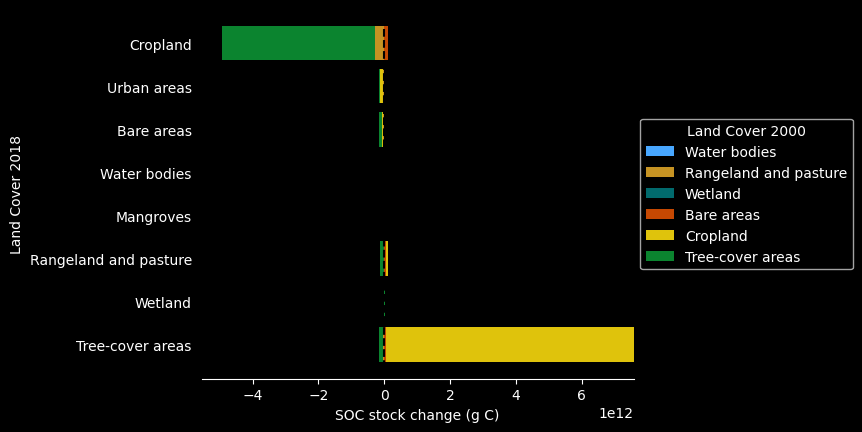

In [63]:
plt = get_plot(land_cover_groups, lc_metadata.parent_colors(), lc_metadata.parent_labels())

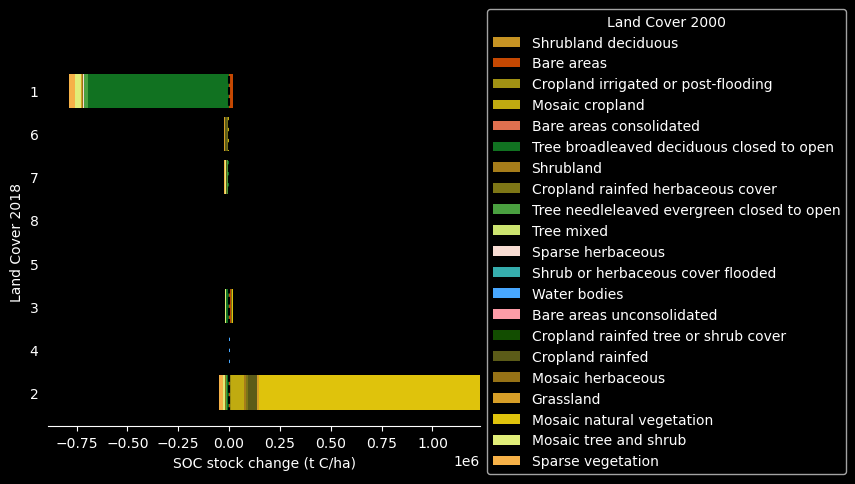

In [7]:
labels = lc_metadata.parent_labels()
labels.update(lc_metadata.child_labels())
colors = lc_metadata.parent_colors()
colors.update(lc_metadata.child_colors())
plt = get_plot(land_cover_group_2018, colors, labels)

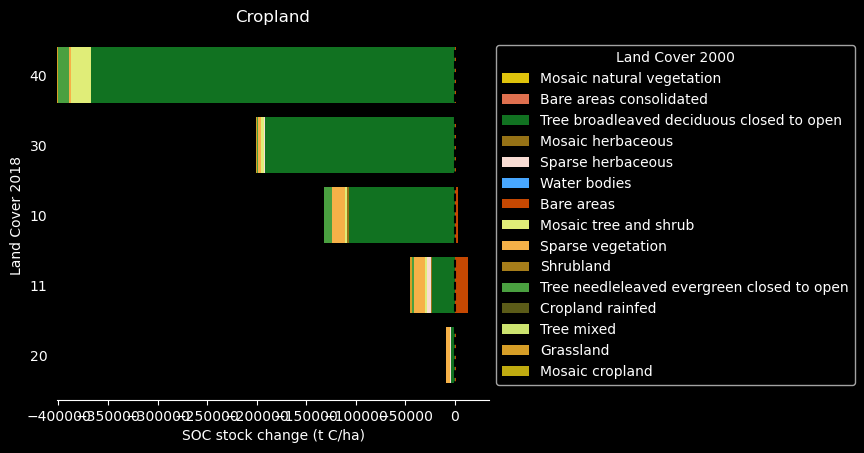

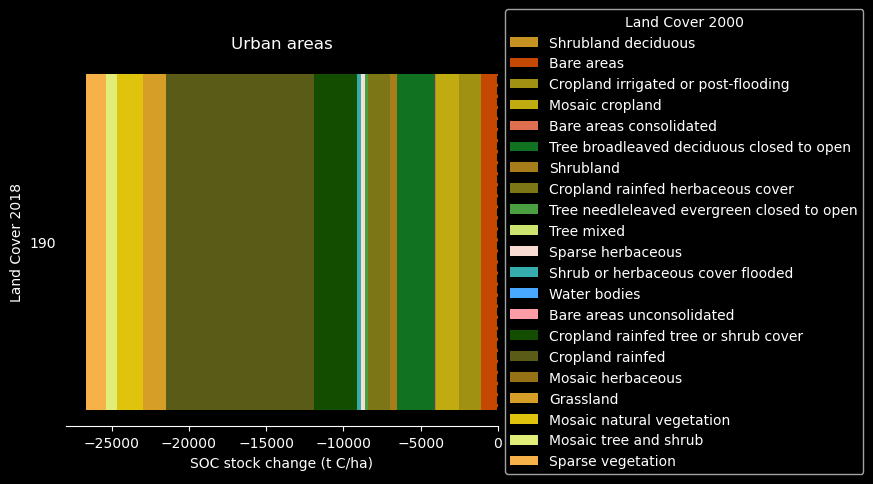

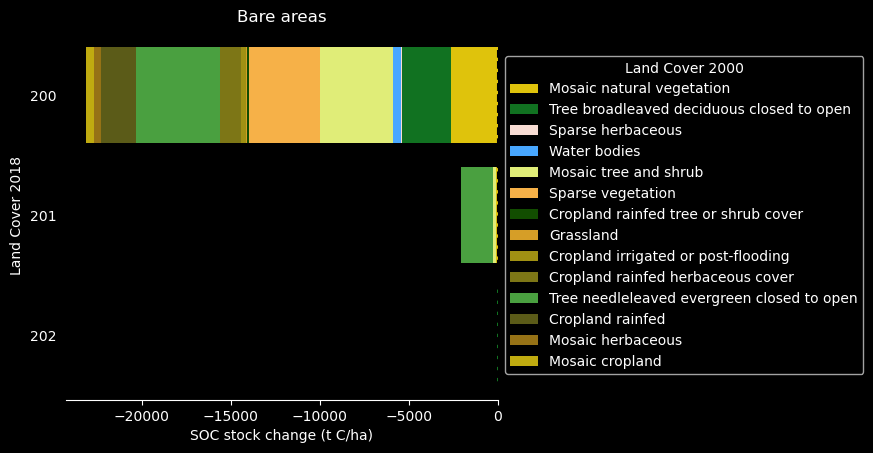

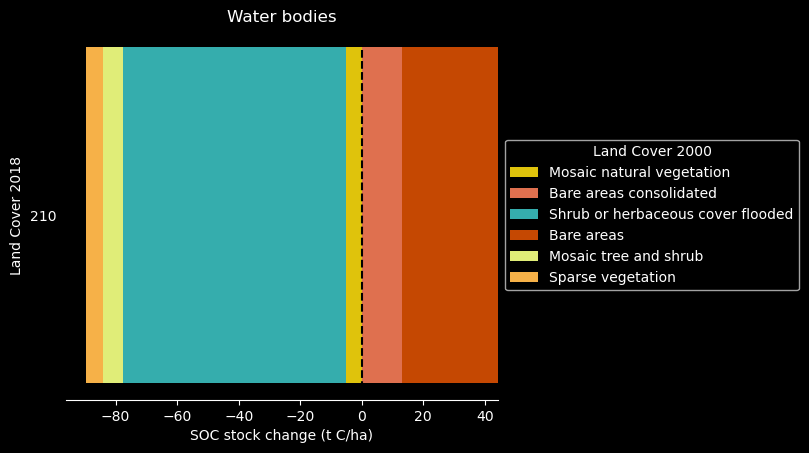

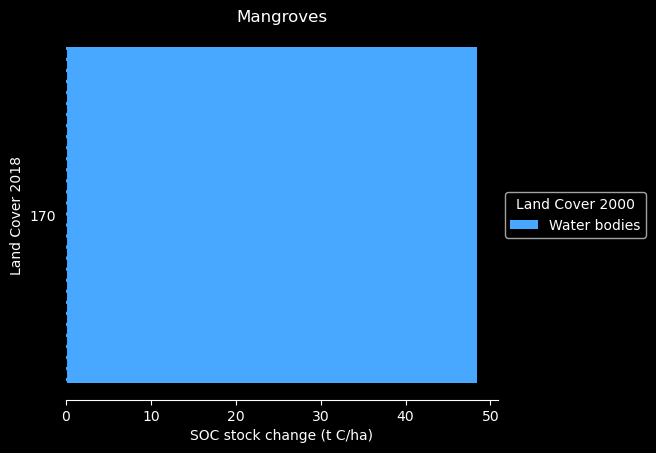

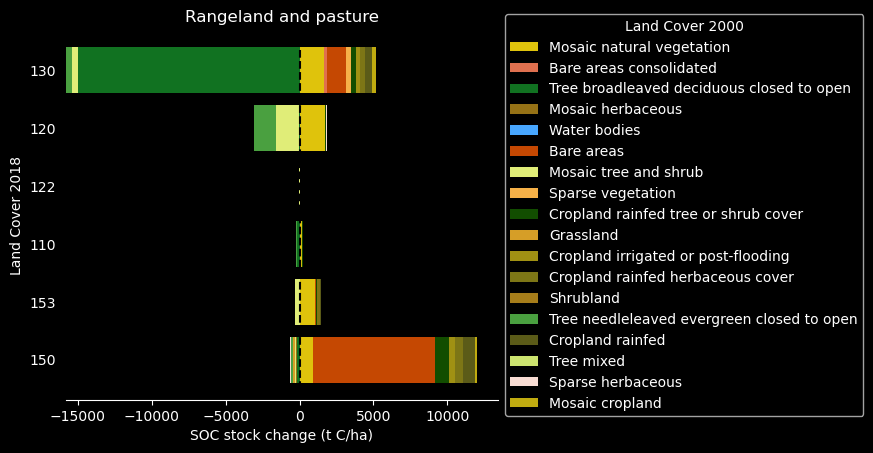

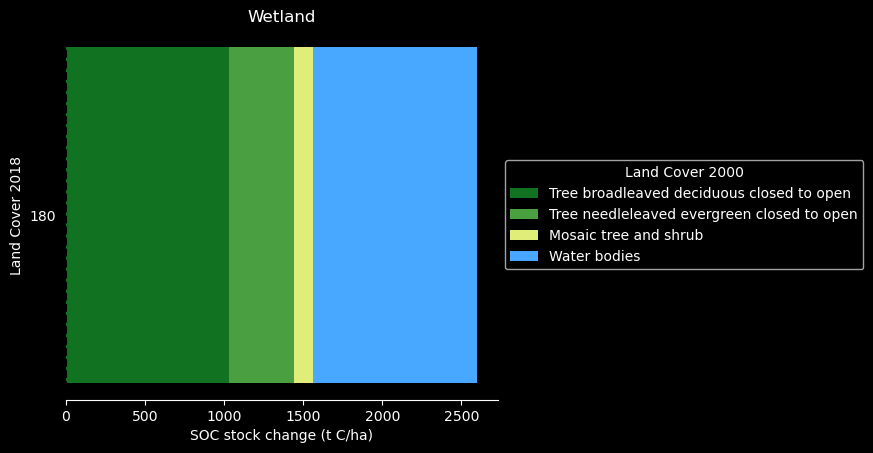

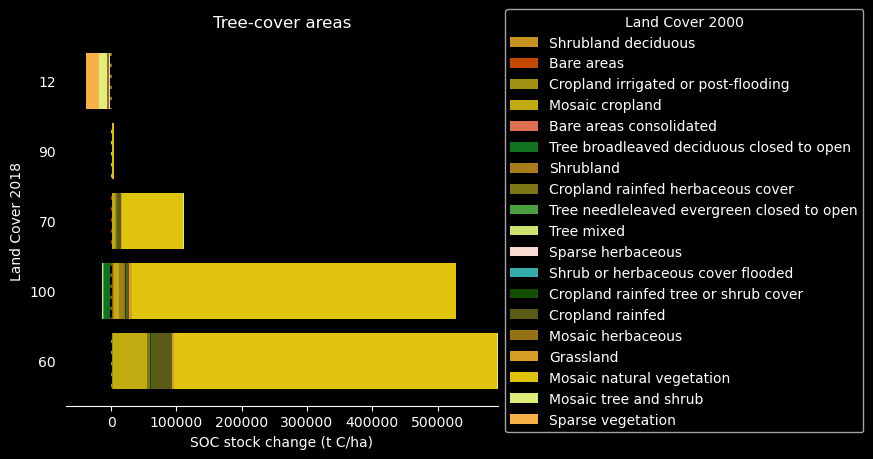

In [8]:
for num in lc_list:
    plt = get_plot(df['land_cover'].iloc[0][num], lc_metadata.child_colors(), lc_metadata.child_labels())
    plt.title(labels[num])

### Future
#### Compute statistics

In [15]:
RASTER_PATH = '../../data/processed/raster_data/'
VECTOR_DATA = '../../data/processed/vector_data/'
VECTOR_PREFIXED = ['political_boundaries']#['political_boundaries', 'biomes']
SCENARIOS = ['crop_I', 'crop_MG', 'crop_MGI', 'grass_part', 'grass_full', 'degradation_ForestToCrop', 'degradation_ForestToGrass', 'degradation_NoDeforestation', 'rewilding']  
READ_DATA_FROM = 's3'#'local_dir'
GROUP_TYPE = 'future'
VARIABLE = 'stocks'

# Read vector data
print("Reading vector data!")
vector = VectorData(VECTOR_DATA, VECTOR_PREFIXED)
vector_data_0 = vector.read_data(suffix='_0.geojson')
vector_data_1 = vector.read_data(suffix='_1.geojson')
vector_data_0['political_boundaries_0'] = vector_data_0['political_boundaries_0'][vector_data_0['political_boundaries_0']['gid_0'].isin(['ESP'])]
vector_data_1['political_boundaries_1'] = vector_data_1['political_boundaries_1'][vector_data_1['political_boundaries_1']['gid_0'].isin(['ESP'])]

# Read raster data
print("Reading raster data!")
lc_metadata = LandCoverData()
raster = LandCoverRasterData(group_type=GROUP_TYPE, data_from=READ_DATA_FROM, path=RASTER_PATH, scenarios=SCENARIOS)
raster_data = raster.read_data() 

# Compute Land Cover Statistics
print("Compute Land Cover Statistics!")
data = {}
lc_statistics = LandCoverStatistics(GROUP_TYPE, raster_data, lc_metadata, SCENARIOS)
# compute level 1 geometries' values
print("Level 1 geometries.")
data.update(lc_statistics.compute_level_1_data(vector_data_1))
# compute level 0 geometries' values
print("Level 0 geometries.")
data.update(lc_statistics.compute_level_0_data(vector_data_0))

### Save data
#print("Saving the data!")
#for geom_type in vector_prefixes:
#    df = pd.concat([data[key] for key in data if geom_type in key])
#    df = df.sort_values(['id_0', 'id'])
#    df['variable'] = VARIABLE
#    df['group_type'] = GROUP_TYPE
#    df.to_csv(f"../../data/processed/precalculations/{geom_type}_land_cover_{GROUP_TYPE}.csv", index=False)

Reading vector data!


100%|██████████| 1/1 [00:12<00:00, 12.73s/it]


Reading raster data!
Compute Land Cover Statistics!
Level 1 geometries.
Computing land cover statistics for vector data -> political_boundaries_1


100%|██████████| 18/18 [02:59<00:00,  9.98s/it]


Level 0 geometries.
Computing land cover statistics for vector data -> political_boundaries_0


100%|██████████| 1/1 [00:00<00:00, 572.37it/s]


#### Display statistics

In [16]:
lc_metadata = LandCoverData()
df = data['political_boundaries_0']

land_cover_groups = df['land_cover_groups'].iloc[0]
land_cover = df['land_cover'].iloc[0]

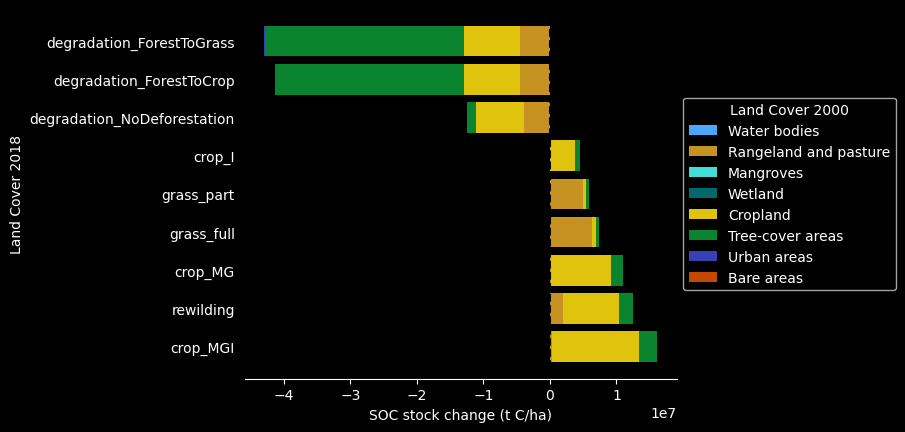

In [17]:
keys = list(land_cover_groups.keys())
plt = get_plot(land_cover_groups, lc_metadata.parent_colors(), lc_metadata.parent_labels(), categories=keys)

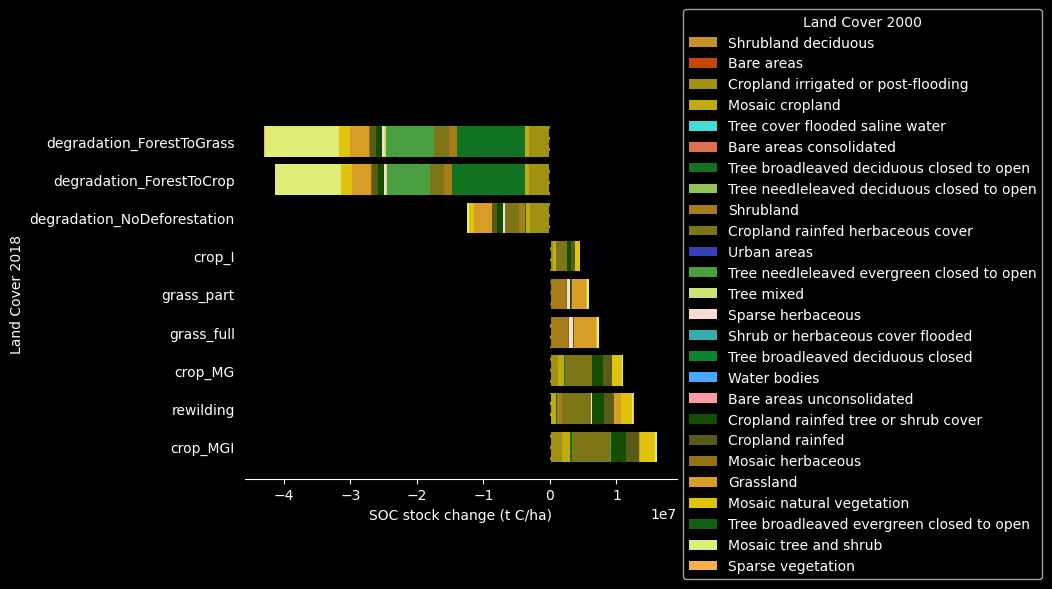

In [18]:
keys = list(land_cover_groups.keys())
plt = get_plot(land_cover, lc_metadata.child_colors(), lc_metadata.child_labels(), categories=keys)